In [12]:
import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
import optax
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from jax import random
from flax import linen as nn
from flax.training import train_state

In [24]:
def harmonic_oscillator(state, t, omega_squared):
    x1, x2 = state
    dx1dt = x2
    dx2dt = -omega_squared * x1
    return jnp.array([dx1dt, dx2dt])


In [46]:
def generate_synthetic_data(omega_squared, num_points=100, t_max=10.0, noise_std=0.1):
    t = jnp.linspace(0, t_max, num_points)
    initial_state = jnp.array([1.0, 0.0])  # Initial conditions: x1(0)=1, x2(0)=0
    true_solution = odeint(harmonic_oscillator, initial_state, t, omega_squared)
    # print(true_solution.shape)
    noisy_solution = true_solution + noise_std * jax.random.normal(jax.random.PRNGKey(0), true_solution.shape)
    # print(noisy_solution.shape)
    return t, jnp.transpose(noisy_solution)

In [47]:
len(generate_synthetic_data(4)[1])

2

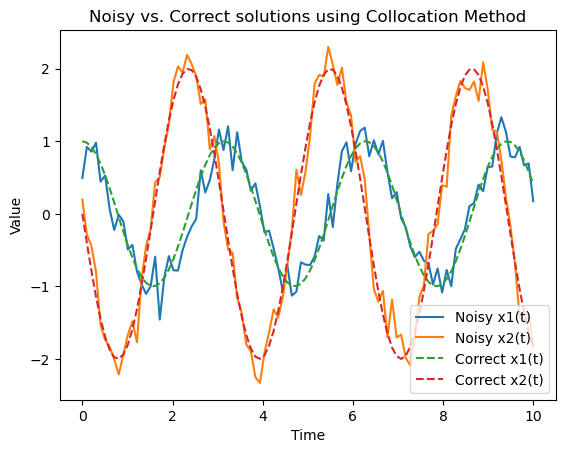

In [51]:
import matplotlib.pyplot as plt

x1_0 = 1
x2_0 = 0

omega = 2.0 
t_test, data = generate_synthetic_data(omega**2, num_points=100, t_max=10.0, noise_std=0.2)

x1_correct = x1_0 * jnp.cos(omega * t_test) + (x2_0 / omega) * jnp.sin(omega * t_test)
x2_correct = x2_0 * jnp.cos(omega * t_test) - x1_0 * omega * jnp.sin(omega * t_test)

# Plot the results
plt.plot(t_test, data[0], label='Noisy x1(t)')
plt.plot(t_test, data[1], label='Noisy x2(t)')
plt.plot(t_test, x1_correct, '--', label='Correct x1(t)')
plt.plot(t_test, x2_correct, '--', label='Correct x2(t)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Noisy vs. Correct solutions using Collocation Method')
plt.show()

In [52]:
class NeuralODE(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(64)(x)
        x = nn.tanh(x)
        x = nn.Dense(64)(x)
        x = nn.tanh(x)
        x = nn.Dense(1)(x)
        return x


In [61]:
def create_train_state(rng, learning_rate):
    model = NeuralODE()
    params = model.init(rng, jnp.ones((1,)))['params']
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)


In [62]:
# Loss function
def loss_fn(params, apply_fn, t, y_true):
    omega_squared = apply_fn({'params': params}, jnp.array([0.0]))[0]  # Predict omega^2
    y_pred = odeint(harmonic_oscillator, y_true[0], t, omega_squared)
    return jnp.mean((y_pred - y_true)**2)


In [63]:
@jax.jit
def train_step(state, t, y_true):
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, state.apply_fn, t, y_true)
    state = state.apply_gradients(grads=grads)
    return state, loss

def train(state, t, y_true, num_epochs=1000):
    for epoch in range(num_epochs):
        state, loss = train_step(state, t, y_true)
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss}')
    return state


In [68]:
# Generate synthetic data
omega_squared_true = 1.0
t, y_true = generate_synthetic_data(omega_squared_true)

# Split the data into training and test sets
t_train, t_test, y_train, y_test = train_test_split(t, jnp.transpose(y_true), test_size=0.2, random_state=42)
y_train = jnp.transpose(y_train)
y_test = jnp.transpose(y_test)

In [69]:
len(y_train)

2

In [70]:
# Initialize the model
rng = random.PRNGKey(0)
learning_rate = 1e-3
state = create_train_state(rng, learning_rate)

# Train the model
state = train(state, t_train, y_train)

ValueError: too many values to unpack (expected 2)

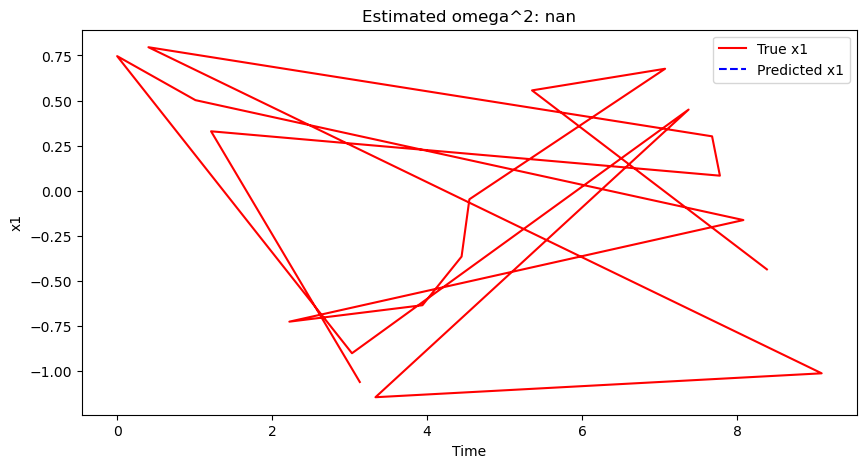

In [21]:
# Predict omega_squared using the trained model
omega_squared_pred = state.apply_fn({'params': state.params}, jnp.array([0.0]))[0]

# Solve the ODE using the predicted parameter
y_pred = odeint(harmonic_oscillator, y_test[0], t_test, omega_squared_pred)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(t_test, y_test[:, 0], 'r-', label='True x1')
plt.plot(t_test, y_pred[:, 0], 'b--', label='Predicted x1')
plt.xlabel('Time')
plt.ylabel('x1')
plt.legend()
plt.title(f'Estimated omega^2: {omega_squared_pred:.4f}')
plt.show()
